In [1]:
import pandas as pd
import numpy as np
import zipfile

## Import Data

In [95]:
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Condo%20Complex%20and%20Units.zip

In [96]:
# with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Condo Complex and Units.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')

In [2]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)
condo_data = pd.read_csv("../../data/raw/EXTR_CondoComplex.csv", encoding='latin-1', low_memory=False)

## Clean Data and Filter For Needed Info

### Property Sales

In [3]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [4]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
2,330395,1610,335000,06/07/2012
3,675260,940,209950,03/06/1998
5,269549,190,154950,07/23/2000
6,638580,110,190000,07/14/2015
8,321165,50,2100000,05/10/2004


### Parcel

In [5]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'PropType', 'SqFtLot', 'WfntLocation',
                 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616110 entries, 0 to 616109
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616110 non-null  int64 
 1   Minor           616110 non-null  int64 
 2   PropType        616110 non-null  object
 3   SqFtLot         616110 non-null  int64 
 4   WfntLocation    616110 non-null  int64 
 5   TrafficNoise    616110 non-null  int64 
 6   AirportNoise    616110 non-null  int64 
 7   PowerLines      616110 non-null  object
 8   OtherNuisances  616110 non-null  object
dtypes: int64(6), object(3)
memory usage: 42.3+ MB


In [6]:
parcel = parcel[(parcel['PropType']=='R') | (parcel['PropType']=='K')]

### Residential Buiding

In [7]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [8]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [9]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


### Merge Property Sales, parcel, and residential building data

In [10]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = (parcel.merge(real_property_sales, on = ['Major', 'Minor'])).merge(residential_building, on = ['Major', 'Minor']).drop_duplicates()
# Change dates to date time format
merged_tables[['Major', 'SqFtLot']].head(20)
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [11]:
merged_tables.shape

(991782, 16)

In [12]:
#Keeping only the most recent Sale_Price

# merged_tables = merged_tables.sort_values(by=['Major', 'DocumentDate'])
# merged_tables.drop_duplicates(subset=['Major', 'Minor'], keep='last', inplace=True)

In [13]:
# Filtering for only 2019 data
start_date = "2019-1-1"
end_date = "2019-12-31"
merged_tables = merged_tables.loc[(merged_tables["DocumentDate"] >= start_date) & (merged_tables["DocumentDate"] <= end_date)]

merged_tables.shape

(29996, 16)

### Condo Units

In [14]:
condo_data.head()

,Major,ComplexType,ComplexDescr,NbrBldgs,NbrStories,NbrUnits,AvgUnitSize,LandPerUnit,ProjectLocation,ProjectAppeal,...,AptConversion,CondoLandType,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode
0,24850,1,41 UNIT CONDO,10,2,41,668,2515,3,3,...,N,1,14000 140TH AVE SE...,14000,,,140TH,AVE,SE,98005
1,25135,1,30 UNIT CONDOMINIUM,6,2,30,1084,2450,1,3,...,Y,1,701 5TH AVE S ...,701,,,5TH,AVE,S,98032
2,31900,2,CONDO IN USE AS APT,3,3,108,717,2530,3,3,...,N,0,15325 NE REDMOND WAY ...,15325,,NE,REDMOND,WAY,,98052
3,46470,4,172 RES UNITS + 1 COM'L UNIT,1,6,173,777,269,3,4,...,N,1,1545 NW 57TH ST ...,1545,,NW,57TH,ST,,98107-3018
4,47100,1,6 UNIT CONDO,1,3,6,1014,833,3,3,...,N,1,2222 NW 58TH ST ...,2222,,NW,58TH,ST,,98107


In [15]:
# change dataframe name to df to make life easier
df = merged_tables #.sort_values(by = 'DocumentDate', ascending=False)

#Create Nuisances Column to replace other nuisance columns
df['Nuisances'] = 'No Nuisances'
df.loc[(df['TrafficNoise']>0), 'Nuisances'] = 'Traffic Noise'
df.loc[(df['AirportNoise']>0), 'Nuisances'] = 'Airport Noise'
df.loc[(df['PowerLines']=='Y'), 'Nuisances'] = 'Power Lines'
df.loc[(df['OtherNuisances']=='Y'), 'Nuisances'] = 'Other Nuisances'
df = df.drop(['TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances', 'SqFtOpenPorch', 'SqFtEnclosedPorch'], axis='columns')

In [16]:
# WFNTLOCATION
# Waterfront location (Source: King County Assessments)
# Value	Definition
# 0	Unknown
# 1	Duwamish
# 2	Elliott Bay
# 3	Puget Sound
# 4	Lake Union
# 5	Ship Canal
# 6	Lake Washington
# 7	Lake Sammamish
# 8	Other lake
# 9	River or slough

df['WaterFrontLocation'] = df.WfntLocation.map({0 : 'None', 1 : 'Duwamish', 2 : 'Elliott Bay', 3 : 'Puget Sound', 4 : 'Lake Union',
                     5 : 'Ship Canal',  6 : 'Lake Washington', 7 : 'Lake Sammamish', 8 : 'Other lake', 9 : 'River or slough'})
df['Is_WaterFrontLocation'] = [1 if i>0 else 0 for i in df.WfntLocation]
df=df.drop('WfntLocation', axis='columns')

In [17]:
df['Has_Nuisance'] = [0 if n == 'No Nuisances' else 1 for n in df['Nuisances']]

# df[['Major', 'Minor', 'SqFtLot']].head()
df.head()

,Major,Minor,PropType,SqFtLot,SalePrice,DocumentDate,NbrLivingUnits,SqFtTotLiving,Has_Porch,Nuisances,WaterFrontLocation,Is_WaterFrontLocation,Has_Nuisance
48,278732,710,R,7416,395000,2019-03-20,1,1820,0,No Nuisances,None,0,0
112,807841,410,R,7424,847888,2019-08-16,1,2200,0,No Nuisances,None,0,0
115,755080,15,R,5000,819000,2019-10-12,1,1800,1,No Nuisances,None,0,0
126,229670,160,R,9853,730000,2019-07-21,1,2410,1,No Nuisances,None,0,0
150,513763,80,R,5239,612000,2019-03-01,1,2798,1,No Nuisances,None,0,0


In [18]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

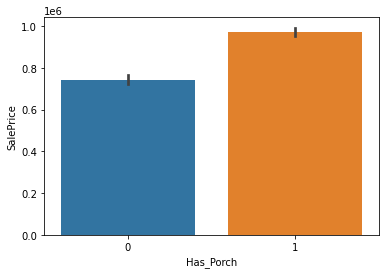

In [20]:
sns.barplot(df['Has_Porch'], df['SalePrice']);

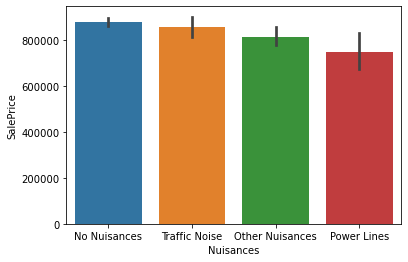

In [21]:
sns.barplot(df['Nuisances'], df['SalePrice']);

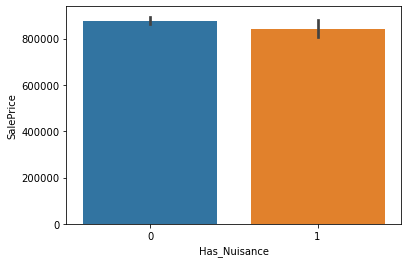

In [22]:
sns.barplot(df['Has_Nuisance'], df['SalePrice']);

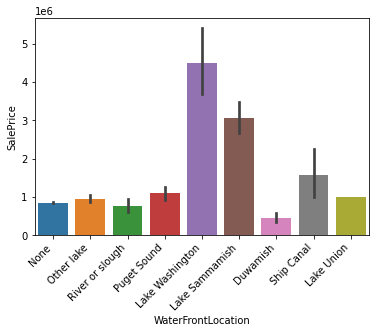

In [23]:
chart = sns.barplot(df.WaterFrontLocation, df.SalePrice)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

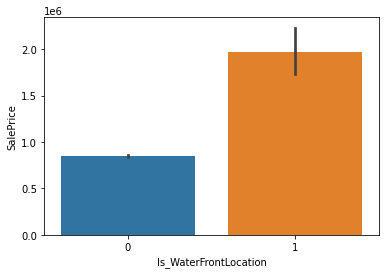

In [24]:
sns.barplot(df.Is_WaterFrontLocation, df.SalePrice);

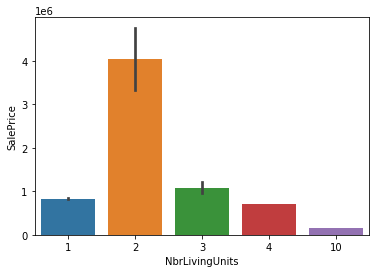

In [25]:
sns.barplot(df.NbrLivingUnits, df.SalePrice);

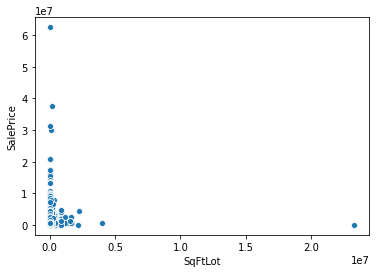

In [26]:
sns.scatterplot(df['SqFtLot'], df['SalePrice'])

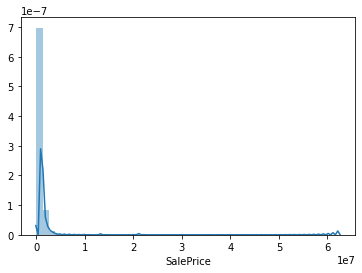

In [27]:
sns.distplot(df['SalePrice'])

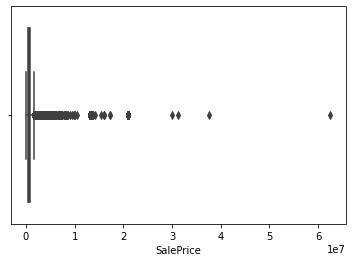

In [28]:
sns.boxplot(df['SalePrice'])

In [71]:
df2 = df[df['SalePrice'].between(df['SalePrice'].quantile(.01), df['SalePrice'].quantile(.99))]

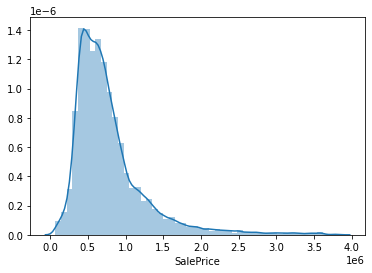

In [72]:
sns.distplot(df2['SalePrice'])

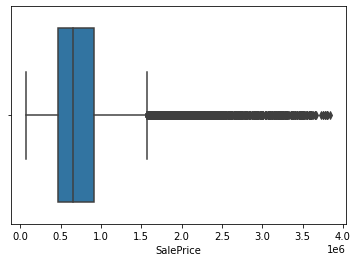

In [73]:
sns.boxplot(df2['SalePrice'])

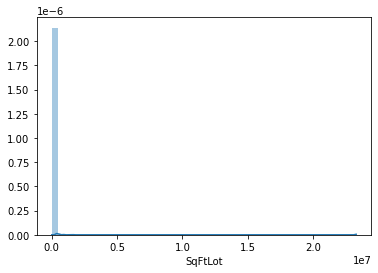

In [74]:
sns.distplot(df2['SqFtLot'])

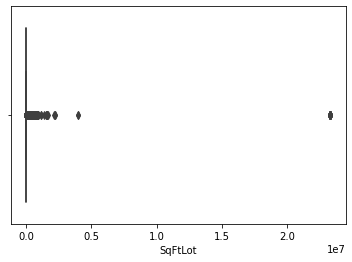

In [75]:
sns.boxplot(df['SqFtLot'])

In [76]:
df2 = df2[df2['SqFtLot'].between(df2['SqFtLot'].quantile(.01), df2['SqFtLot'].quantile(.99))]

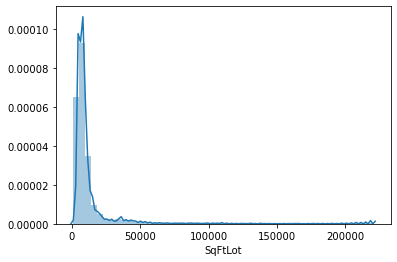

In [77]:
sns.distplot(df2['SqFtLot'])

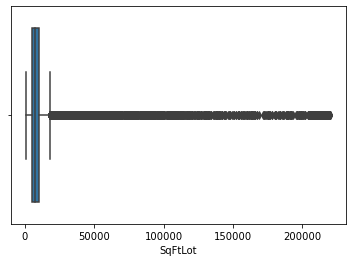

In [78]:
sns.boxplot(df2['SqFtLot'])

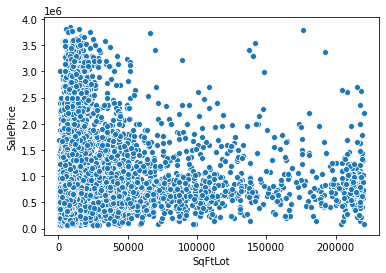

In [79]:
sns.scatterplot(df2['SqFtLot'], df2['SalePrice'])

In [80]:
df2=df2.reset_index(drop=True)

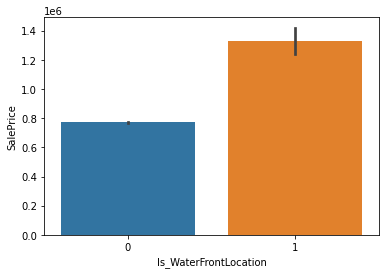

In [81]:
sns.barplot(df2.Is_WaterFrontLocation, df2.SalePrice);

In [82]:
df2.head()

,Major,Minor,PropType,SqFtLot,SalePrice,DocumentDate,NbrLivingUnits,SqFtTotLiving,Has_Porch,Nuisances,WaterFrontLocation,Is_WaterFrontLocation,Has_Nuisance
0,278732,710,R,7416,395000,2019-03-20,1,1820,0,No Nuisances,None,0,0
1,807841,410,R,7424,847888,2019-08-16,1,2200,0,No Nuisances,None,0,0
2,755080,15,R,5000,819000,2019-10-12,1,1800,1,No Nuisances,None,0,0
3,229670,160,R,9853,730000,2019-07-21,1,2410,1,No Nuisances,None,0,0
4,513763,80,R,5239,612000,2019-03-01,1,2798,1,No Nuisances,None,0,0


In [83]:
df2.to_csv('../../data/clean/KingCountyHousingData.csv')

In [84]:
df2['SalePrice'].max()

3842000